## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import random
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Callable, Tuple
import collections
import gymnasium as gym
from gymnasium import spaces
import pygame
from cube import CubeEnv

## Environnement

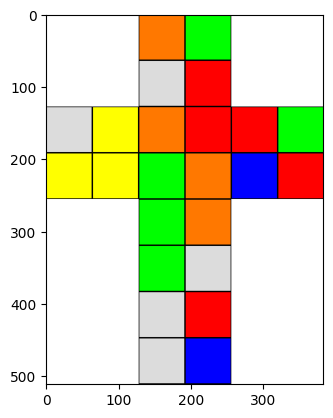

In [2]:
env = CubeEnv(render_mode="rgb_array") # human ne marche pas pour l'instant
env.reset()
env.shuffle(1)
env.render()

## Modèle utilisé comme contrôleur

In [3]:
# Source: TD6 INF581
CUBE_SIZE=2

n_input  = 6 * 6 * env.size * env.size # 6 = nombre de faces // size^2 = nombre de couleurs par face // 6 = one-hot encoding des couleurs
n_output = env.action_space.size()
n_dense  = 256 # au pif, un pax avait choisi 1024 pour le 3x3

# Setup cuda/cpu device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
print(f"PyTorch will train neural networks on {device}")

class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        
        self.l1 = nn.Linear(n_input, n_dense)
        self.l2 = nn.Linear(n_dense, n_dense)
        self.l3 = nn.Linear(n_dense, n_dense)
        self.l4 = nn.Linear(n_dense, n_output)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        return x

AttributeError: 'Discrete' object has no attribute 'size'

## Policy

In [10]:
class EpsilonGreedy:
    
    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay: float,
                 q_network: torch.nn.Module):
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        
        return torch.argmax(q_values, dim=1).item()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

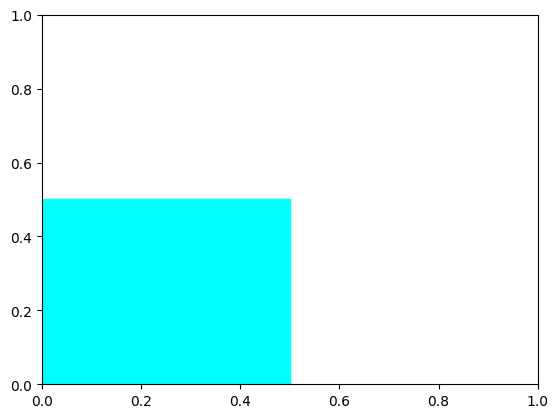

In [12]:
fig, ax = plt.subplots()
rect = patches.Rectangle((0, 0), width=.5, height=.5, color='aqua')
ax.add_patch(rect)
fig.canvas.draw()

## Learning rate scheduler

In [13]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self):
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

## Replay buffer

In [15]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

## Train function

### Observations about the problem

- This problem is characterized by its vast state space and the scarcity of the reward that exists only when reaching the solved state if we don't introduce knowledge into the model. We could potentially introduce at one point a reward function that gives information about the quality of the current state.

- The system is deterministic and we know all the transitions of it. 

### We decide for now to not introduce any knowledge and have a reward of 1 if reaching the solved state and -1 else


### Important points on why we can't simply do Q Learning:

1) We need the initial position to be close to the solved state else it will be impossible for the agent to get to this state (the only one giving a reward) given the extremely vast state space.
    -> We take as a distance to the solved state the number of random shuffles that are done from it.

2) The system is completely deterministic and we know all the transitions. It is thus better to work by updating the state_values instead of the q_values as it is 6x smaller (6 actions possible for a 2x2 rubiks cube).

3) We can't do full episodes as if the agent explores / goes into an unseen part of the rubiks cube he is very likely to get "lost" in it and do thousands of iterations before arriving to the solved state if it even reaches it. 
   

In [ ]:
def train_adi(env: CubeEnv,
                     q_network: torch.nn.Module,
                     target_q_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: Callable,
                     epsilon_greedy: EpsilonGreedy,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     num_episodes_per_shuffle: int, #For each shuffle step how many episodes do we do
                     num_shuffles: int, #How deep we go into e
                     gamma: float,
                     batch_size: int,
                     target_q_network_sync_period: int) -> List[float]:
    iteration = 0
    episode_reward_list = []

    for n_shuffle in tqdm(range(1,num_shuffles+1)):

        for episode in range(1,num_episodes_per_shuffle) :
                
            state, _ = env.reset()
            episode_reward = 0


            while True:

                # Get action, next_state and reward
                action = epsilon_greedy(state)

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                replay_buffer.add(state, action, reward, next_state, done)

                episode_reward += reward

                # Update the q_network weights with a batch of experiences from the buffer
                if len(replay_buffer) > batch_size:
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                    # Convert to PyTorch tensors
                    batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32, device=device)
                    batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                    batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                    batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float32, device=device)
                    batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                    target_tensor = batch_rewards_tensor + gamma * target_q_network(batch_next_states_tensor).max(dim=1)[0] * (1 - batch_dones_tensor)
                    output_tensor = q_network(batch_states_tensor).index_select(dim=1, index=batch_actions_tensor)
                    loss = loss_fn(output_tensor, target_tensor)

                    # Optimize the model
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    lr_scheduler.step()

                # Update the target q-network

                # Every few training steps (e.g., every 100 steps), the weights of the target network are updated with the weights of the Q-network
                if iteration % target_q_network_sync_period == 0:
                    target_q_network.load_state_dict(q_network.state_dict())

                iteration += 1

                if done:
                    break

                state = next_state

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

## Train it

In [ ]:

NUMBER_OF_TRAININGS = 20
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    q_network = QNetwork().to(device) # q network
    target_q_network = QNetwork().to(device) # target q network
    target_q_network.load_state_dict(q_network.state_dict()) # load same weights

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=150,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=30)
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(np.array(dqn2_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

# Save the action-value estimation function
torch.save(q_network, "dqn2_q_network.pth")